## 1. 사용할 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm 
from konlpy.tag import Okt
import itertools
from collections import Counter
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
import gensim
from gensim import models
import pyLDAvis.gensim 
import matplotlib.pyplot as plt

In [2]:
import matplotlib.font_manager as fm
from matplotlib import rc
font_name = fm.FontProperties(fname="c:/Windows/Fonts/H2GTRE.ttf").get_name()
rc('font', family=font_name)

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2. 데이터 불러오기

In [3]:
data = pd.read_excel('preprocessed수정본.xlsx', sheet_name = '바이크')
data.head()

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


reviewId              userName  \
0  2890cae1-b71f-4312-8126-423e6c5de920                 치천후TV   
1  de449299-787d-46df-a671-e9d6aedcd9f8  LAIKA SPACEDOG (라이카)   
2  52590191-7db4-4870-aedf-27e76339e645                    후이   
3  4c3a269d-9550-4d99-b009-6374ad77c583                   장용호   
4  af48a751-9509-4f46-b2a0-13e992bf7bf2                    사람   

                                             content  \
0  자전거 자주이용하고잇엇는데 3일 전부터 거리에 쉽게 찾을수잇던 카카오바이크가 검색창...   
1  카카오 바이크 대여하려고 하면 블루투스 오류라고 하면서 대여가 안되는데 어떻게 해결...   
2  아니 왜 택시 바이크 등등 누르기만 하면 앱이 꺼지나요,,, 몇번을 다시 깔았는데도...   
3  카카오 (바이크) 연락이나 공지 알림도 없이 위치릉 갑자기 축소 시켜서 괜히 시간만...   
4  분명 바이크 빌릴때 전량 13%있었는데 1km갈수있을줄 알았더니 500m에서 배터리...   

                                        preprocessed          at  score  
0  자전거 자주 용하다 거리 카카오 바이크 검색 넓다 지역 대도 바이크 사업 가요 아니...  2023-05-02      1  
1      카카오 바이크 대여 블루투스 오류 대여 안되다 어떻다 해결 하나요 지난달 멀쩡하다  2023-04-27      2  
2                      아니다 택시 바이크 등등 누르기 몇번 다시 난리 아주  2023-04-26      1  
3   카카오 바이크 연락 공지 알림 위치 갑자기 축소 시간 뻘짓해 결곡 버스 타고 요금 이용  2023-04-25      1  
4      분명 바이크 전량 있다 배터리 페달 무겁다 끌바 서비스 지역 이탈 이상 끌바 환불  2023-04-24      1

## 3. 데이터 전처리

### (1) 불용어 정의

In [4]:
# 불용어 리스트 생성(형용사)
stopwords = ['대한', '있다', '없다', '아니다', '같다']

stopwords2 = ''
f = open("stopwords(2).txt", 'r')
line = f.readline()
stopwords2 = stopwords2 + line
f.close()
stopwords2 = stopwords2.split(',')

stopwords = stopwords + stopwords2

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (2) Replace Words

In [5]:
f = open("replacing.txt", 'r', encoding = 'utf-8')
line = f.readlines()
line = [l.replace('\n','') for l in line]
line = [l.split('=') for l in line]
line[:3]

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['기다렸는데', '기다리다'], ['늦게오고', '늦다'], ['늦게 오고', '늦다']]

In [6]:
def Word_transform(Text, word, to_word):
    Text = str(Text).replace(word,to_word)
    return Text

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
for i in range(len(line)):
    data['content'] = [Word_transform(txt, line[i][0], line[i][1]) for txt in data['content']]    

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (3) Tokenizer 정의 (명사, 동사, 형용사)

In [8]:
def change_words(word, word1, word2):
    if word == word1:
        return word2
    else:
        return word

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
okt = Okt()
def my_tokenizer(doc):
    tokens = [token for token, pos in okt.pos(doc, norm=True, stem=True) if pos in ['Noun', 'Adjective', 'Verb']] # 토큰화, 명사만 출력
    tokens = [word for word in tokens if (word not in stopwords)] # 불용어 제거
    tokens = [change_words(word, '딴', '다른') for word in tokens]
    tokens = [change_words(word, '아치', '양아치') for word in tokens]
    tokens = [change_words(word, '갑', '갑질') for word in tokens]
    tokens = [change_words(word, '퀵', '퀵서비스') for word in tokens]
    tokens = [word for word in tokens if (len(word) > 1)]# 1글자 제외
    return tokens

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (4) Token 생성

In [10]:
Token = [my_tokenizer(sentence) for sentence in tqdm(data['content'])]

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [00:10<00:00, 39.75it/s]


### (5) 단어 빈도 수 및 전처리 결과 저장

In [11]:
def word_frequency(Token):
    flatten_tokens = list(itertools.chain(*Token))
    token_count = Counter(flatten_tokens)
    word_count = pd.DataFrame.from_dict(token_count, orient='index').reset_index()
    word_count.columns = ['Word', 'Frequency']
    word_count = word_count.sort_values(by = 'Frequency', ascending = False).reset_index(drop = True)
    return word_count

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
sentences = [" ".join(tok) for tok in Token]
data['preprocessed'] = sentences

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
word_count = word_frequency(Token)
word_count.head(20)

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Word  Frequency
0   바이크        551
1   카카오        300
2    이용        166
3   자전거        116
4    위치         96
5   서비스         89
6    좋다         76
7    택시         70
8    사용         67
9    지역         66
10   찾다         64
11   주차         58
12   뜨다         56
13  해주다         55
14   요금         47
15   결제         45
16   오류         44
17   많다         43
18   고장         40
19   사람         40

In [14]:
data.loc[:, ['reviewId','userName','content','preprocessed','at', 'score']].to_excel('preprocessed.xlsx', index = False)
word_count.to_csv('word_count.csv', index = False, encoding = 'euc-kr')

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 4. 토픽 분석

In [15]:
id2word=corpora.Dictionary(Token)
id2word.filter_extremes(no_below = 3) #3회 이하로 등장한 단어는 삭제
texts = Token
corpus=[id2word.doc2bow(text) for text in texts]

os.makedirs('./토픽분석', exist_ok = True)

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (1) 적절한 토픽 개수 선정

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
    plt.savefig('./토픽분석/토픽개수선정.png')
    plt.show()
    
    return model_list, coherence_values

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


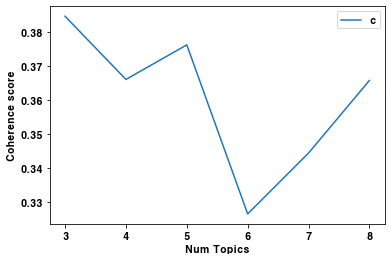

In [30]:
start_topic_num = 3
end_topic_num = 8
step = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start_topic_num, limit=end_topic_num+1, step=step)

In [31]:
best_topic_num = range(start_topic_num, end_topic_num+1, step)[coherence_values.index(max(coherence_values))]
print("Best topic number: {}".format(best_topic_num))

Best topic number: 3


c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### (2) 최적의 토픽 개수에 대해서 토픽별 단어 저장

In [32]:
best_model = model_list[coherence_values.index(max(coherence_values))]
topics = best_model.print_topics(num_words=8) 
topics

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.044*"이용" + 0.024*"자전거" + 0.019*"요금" + 0.017*"찾다" + 0.016*"택시" + 0.014*"사용" + 0.012*"좋다" + 0.012*"주차"'),
 (1,
  '0.032*"지역" + 0.024*"이용" + 0.020*"주차" + 0.019*"서비스" + 0.018*"좋다" + 0.016*"택시" + 0.016*"자전거" + 0.012*"해주다"'),
 (2,
  '0.031*"위치" + 0.031*"이용" + 0.028*"서비스" + 0.027*"자전거" + 0.016*"좋다" + 0.016*"뜨다" + 0.014*"사용" + 0.013*"찾다"')]

In [33]:
topic_words = dict()

for i in range(best_topic_num):
    words = [word for (word, prob) in best_model.show_topic(i, 20)]
    topic_words['Topic_' + str(i + 1)] = words
    
topic_words = pd.DataFrame(topic_words)

os.makedirs('./토픽분석', exist_ok = True)

topic_words.to_excel(os.path.join('./토픽분석', 'Topic Words.xlsx'), index = False)
topic_words.head(10)

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic_1 Topic_2 Topic_3
0      이용      지역      위치
1     자전거      이용      이용
2      요금      주차     서비스
3      찾다     서비스     자전거
4      택시      좋다      좋다
5      사용      택시      뜨다
6      좋다     자전거      사용
7      주차     해주다      찾다
8      위치      사용     해주다
9      결제    업데이트      택시

### (3) 토픽 모델링 시각화

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, os.path.join('./토픽분석', 'Topic Plot.html'))

c:\users\user\miniconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\user\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
